# Linear Penalized Regs

## Penalized Linear Regressions: A Simulation Experiment

## Data Generating Process: Approximately Sparse

In [47]:
import random
random.seed(1)
import numpy as np
import math
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

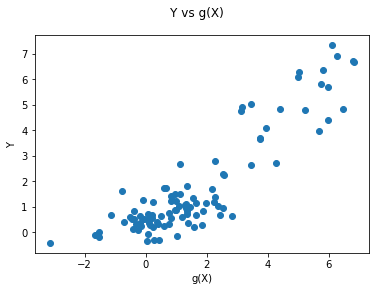

theoretical R2:, 0.856684252638448


0.856684252638448

In [48]:
n = 100
p = 400

Z = np.random.uniform( low = 0 , high = 1 , size = n) - 1/2 

W = ( np.random.uniform( low = 0 , high = 1 , size = n * p ) - 1/2 ).\
        reshape( n , p )

beta = ((1/ np.arange(1, p + 1 )) ** 2)

gX = np.exp( 4 * Z ) + (W @ beta)
gX

X = np.concatenate( ( Z.reshape(Z.size, 1), Z.reshape(Z.size, 1) \
                     ** 2, Z.reshape(Z.size, 1) ** 3, W ) , axis = 1 )

mean = 0
sd = 1
Y = gX + np.random.normal( mean , sd, n )

# We use package Glmnet to carry out predictions using cross-validated lasso, ridge, and elastic net
fig = plt.figure()
fig.suptitle('Y vs g(X)')
ax = fig.add_subplot(111)
plt.scatter( Y, gX)
plt.xlabel('g(X)')
plt.ylabel('Y')
plt.show()

print( f"theoretical R2:, {np.var(gX) / np.var( Y )}" ) 

np.var(gX) / np.var( Y ) #theoretical R-square in the simulation example

We use package Glmnet to carry out predictions using cross-validated lasso, ridge, and elastic net

We should know that **cv.glmnet** function in r **standarize** ***X*** data by default. So, we have to standarize our data before the execution of sklearn package. The **normalize** parameter will help for this. However, the function cv.glamnet  is also standarizing the **Y** [variable](https://web.stanford.edu/~hastie/glmnet/glmnet_alpha.html) and then unstadarize the coefficients from the regression. To do this with sklearn, we will standarize the **Y** variable before fitting with **StandardScaler** function. Finally, the r-function uses 10 folds by default so we will adjust our model to use **cv=10** ten folds.\
\
The parameter **l1_ratio** corresponds to **alpha** in the glmnet R package while **alpha** corresponds to the **lambda** parameter in **glmnet**. Specifically, **l1_ratio = 1** is the lasso penalty. Currently, **l1_ratio <= 0.01** is not reliable, unless you supply your own sequence of **alpha**.

In [49]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, ElasticNetCV

In [67]:
# Reshaping Y variable
Y_vec = Y.reshape( Y.size, 1)

# Scalar distribution
scaler = StandardScaler()
scaler.fit( Y_vec )
std_Y = scaler.transform( Y_vec )

# Regressions
fit_lasso_cv = LassoCV(cv = 10 , random_state = 0 , normalize = True ).fit( X, std_Y )
fit_ridge = ElasticNetCV( cv = 10 , normalize = True , random_state = 0 , l1_ratio = 0.0001 ).fit( X, std_Y )
fit_elnet = ElasticNetCV( cv = 10 , normalize = True , random_state = 0 , l1_ratio = 0.5, max_iter = 100000 ).fit( X, std_Y )

# Predictions
yhat_lasso_cv = scaler.inverse_transform( fit_lasso_cv.predict( X ).reshape(-1,1) )
yhat_ridge = scaler.inverse_transform( fit_ridge.predict( X ).reshape(-1,1) )
yhat_elnet = scaler.inverse_transform( fit_elnet.predict( X ).reshape(-1,1) )

In [69]:
import statsmodels.api as sm

In [72]:
MSE_lasso_cv = sm.OLS( ((gX.reshape(-1,1) - yhat_lasso_cv)**2 ) , np.ones( yhat_lasso_cv.shape )  ).fit().summary2().tables[1].round(3)
MSE_ridge = sm.OLS( ((gX.reshape(-1,1) - yhat_ridge)**2 ) , np.ones( yhat_ridge.size )  ).fit().summary2().tables[1].round(3)
MSE_elnet = sm.OLS( ((gX.reshape(-1,1) - yhat_elnet)**2 ) , np.ones( yhat_elnet.size )  ).fit().summary2().tables[1].round(3)
# our coefficient of MSE_elnet are far from r output

Here we compute the lasso and ols post lasso using plug-in choices for penalty levels, using package hdm

Rlasso functionality: it is searching the right set of regressors. This function was made for the case of ***p*** regressors and ***n*** observations where ***p >>>> n***. It assumes that the error is i.i.d. The errors may be non-Gaussian or heteroscedastic.\
The post lasso function makes OLS with the selected ***T*** regressors.
To select those parameters, they use $\lambda$ as variable to penalize\
**Funny thing: the function rlasso was named like that because it is the "rigorous" Lasso.**\
We find a Python code that tries to replicate the main function of hdm r-package. I was made by [Max Huppertz](https://maxhuppertz.github.io/code/). His library is this [repository](https://github.com/maxhuppertz/hdmpy). Download its repository and copy this folder to your site-packages folder. In my case it is located here ***C:\Python\Python38\Lib\site-packages*** .

We need to install this package ***pip install multiprocess***.

In [73]:
import hdmpy

In [74]:
fit_rlasso = hdmpy.rlasso(X, Y, post = False)
fit_rlasso_post = hdmpy.rlasso(X, Y, post = True)

yhat_rlasso = Y - fit_rlasso.est['residuals'].reshape( Y.size,  )
yhat_rlasso_post = Y - fit_rlasso_post.est['residuals'].reshape( Y.size ,  )

MSE_lasso = sm.OLS( ((gX - yhat_rlasso)**2 ) , np.ones( yhat_rlasso.size )  ).fit().summary2().tables[1].round(3)
MSE_lasso_post = sm.OLS( ((gX - yhat_rlasso_post)**2 ) , np.ones( yhat_rlasso_post.size )  ).fit().summary2().tables[1].round(3)


In [78]:
def lava_predict( x, y, iteration = 5 ):
    
    g1_rlasso = hdmpy.rlasso( x, y , post = False )
    g1 = y - g1_rlasso.est['residuals'].reshape( g1_rlasso.est['residuals'].size, )
    
    new_dep_var = y-g1
    new_dep_var_vec = new_dep_var.reshape( new_dep_var.size, 1 )
    
    # Scalar distribution
    scaler = StandardScaler()
    scaler.fit( new_dep_var_vec )
    std_new_dep_var_vec = scaler.transform( new_dep_var_vec )
    
    fit_ridge_m1 = ElasticNetCV( cv = 10 , normalize = True , random_state = 0 , l1_ratio = 0.0001, alphas = np.array([20]) ).fit( x, std_new_dep_var_vec )
    m1 = scaler.inverse_transform( fit_ridge_m1.predict( x ) )
    
    i = 1
    while i <= iteration:
        
        g1_rlasso = hdmpy.rlasso( x, y , post = False )
        g1 = y - g1_rlasso.est['residuals'].reshape( g1_rlasso.est['residuals'].size, )

        new_dep_var = y-g1
        new_dep_var_vec = new_dep_var.reshape( new_dep_var.size, 1 )

        # Scalar distribution
        scaler = StandardScaler()
        scaler.fit( new_dep_var_vec )
        std_new_dep_var_vec = scaler.transform( new_dep_var_vec )

        fit_ridge_m1 = ElasticNetCV( cv = 10 , normalize = True , random_state = 0 , l1_ratio = 0.0001, alphas = np.array([20]) ).fit( x, std_new_dep_var_vec )
        m1 = scaler.inverse_transform( fit_ridge_m1.predict( x ) )
        
        i = i + 1
        
    return ( g1 + m1 )
        

Next we code up lava, which alternates the fitting of lasso and ridge

In [17]:
print(X.shape)
print(Y.shape)

(100, 403)
(100,)


In [84]:
yhat_lava = lava_predict( X, Y.reshape(-1,1) )

ValueError: Found input variables with inconsistent numbers of samples: [100, 10000]

In [24]:
yhat_lava = lava_predict( X.reshape(-1,X.shape[1]), Y.reshape(-1,1) )

ValueError: Found input variables with inconsistent numbers of samples: [100, 10000]

In [79]:
yhat_lava = lava_predict( X, Y )
MSE_lava = sm.OLS( ((gX - yhat_lava)**2 ) , np.ones( yhat_lava.size )  ).fit().summary2().tables[1].round(3)

ValueError: Expected 2D array, got 1D array instead:
array=[ 1.31925564e-04 -2.78839475e-03 -1.68320499e-03 -9.86061094e-04
 -6.09981926e-04 -9.65894525e-04 -4.63284613e-04 -1.86797011e-03
 -3.97059470e-03  1.33980212e-03  4.18719814e-03  2.72843430e-04
 -2.49896203e-03 -2.20497766e-04  4.98730992e-04 -2.57469264e-03
  7.29635781e-04 -1.07971041e-03 -2.43211984e-03  4.84705955e-04
  1.64541374e-03 -1.42337862e-03  3.66813776e-03  1.14128324e-03
 -3.37015422e-03 -8.25208105e-04 -2.94022157e-03 -6.64163862e-04
 -5.30186274e-04  4.58853580e-04  1.23865430e-03 -2.47826652e-03
  7.66564851e-04 -2.65006223e-04 -1.66809556e-03  1.03621871e-03
 -2.48415901e-04  1.96616609e-03 -3.50636159e-03 -8.38534525e-05
  4.65818188e-03 -3.54523907e-03  1.36174951e-03  2.24974736e-03
 -4.53832909e-04 -5.44984425e-05 -2.23070348e-03  1.69157993e-03
 -1.13473036e-03 -9.77185673e-04  1.50540068e-03  4.67934176e-04
 -2.65827305e-03  2.22059526e-03  4.48838171e-03 -1.98035964e-03
  1.71256910e-03 -1.20203438e-03  4.56793534e-04 -1.26105292e-03
 -1.36733032e-03  9.70161389e-04  1.80147656e-03  2.93587216e-03
  4.66138416e-03  1.21822944e-03  1.94528278e-03  2.07148746e-03
 -5.14311643e-04  3.01601999e-04  1.20089862e-03 -3.88437169e-04
  9.13293484e-04  7.62634598e-04 -4.04671854e-04 -1.59235251e-04
 -4.11963455e-03  3.82823717e-03 -3.92173087e-03  5.18125232e-04
 -1.53081362e-04  2.95436086e-03 -1.98988426e-04 -2.40096108e-04
  2.36462428e-03 -6.17562432e-04 -6.65999005e-04  5.60859346e-04
  1.30314057e-03 -3.02589155e-04 -1.23167525e-03 -3.34420713e-04
  2.25021215e-04  1.20222913e-03 -4.70889652e-04 -2.03044053e-04
  2.84814526e-04 -2.31718605e-04 -1.00252299e-03 -2.32271723e-04].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [68]:
yhat_lava

array([ 2.26842737,  0.3518921 ,  2.16437144,  4.58793136,  0.32475748,
        3.97702414,  0.07475153,  1.12466672,  1.45819748,  4.52755667,
        2.22608792,  0.61142399,  2.83385267,  0.6758044 ,  3.28082626,
        2.05888173,  1.09627703,  0.4913427 ,  1.71447345,  0.6724335 ,
        1.37113921,  0.68072597,  0.69517606,  4.30631518, -0.46330898,
        1.21065291,  0.30399639,  0.88090279,  3.07432376,  0.76843096,
        1.07924247,  3.66727024,  2.06110446,  4.71165235,  4.25076401,
       -0.14401881,  0.61526592,  0.46454401,  1.20921572,  2.74556104,
        1.80446737,  0.9708959 ,  3.14333617,  1.49602814,  0.64854985,
        1.97885295,  3.08412745,  0.9494072 ,  0.83537556,  1.50126836,
        4.25175887,  1.23612387,  0.95633362,  1.57570254,  4.86246285,
        0.78753903,  1.28352589,  2.22902318,  0.60575163,  1.2765798 ,
        4.07543612,  3.54192064, -0.66750971,  1.24721993,  0.87600809,
        0.91315424,  1.31829304,  2.00333569,  1.61022961,  1.03

In [69]:
import pandas as pd

In [70]:
table2 = np.zeros( (6, 2) )

table2[0, 0:] = MSE_lasso_cv.iloc[0, 0:2].to_list()
table2[1, 0:] = MSE_ridge.iloc[0, 0:2].to_list()
table2[2, 0:] = MSE_elnet.iloc[0, 0:2].to_list()
table2[3, 0:] = MSE_lasso.iloc[0, 0:2].to_list()
table2[4, 0:] = MSE_lasso_post.iloc[0, 0:2].to_list()
table2[5, 0:] = MSE_lava.iloc[0, 0:2].to_list()



table2_pandas = pd.DataFrame( table2, columns = [ "MSA","S.E. for MSA" ])
table2_pandas.index = [ "Cross-Validated Lasso",\
                       "Cross-Validated Ridge", "Cross-Validated elnet",\
                       "Lasso", "Post-Lasso", "Lava" ]
table2_pandas = table2_pandas.round(3)
table2_html = table2_pandas.to_html()
table2_pandas

,MSA,S.E. for MSA
Cross-Validated Lasso,1.303,0.195
Cross-Validated Ridge,3.437,0.488
Cross-Validated elnet,1.510,0.229
Lasso,0.863,0.123
Post-Lasso,1.354,0.186
Lava,0.860,0.122


In [71]:
import matplotlib.pyplot as plt

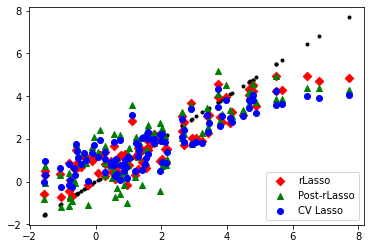

In [72]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter( gX, gX , marker = '.', c = 'black' )
ax1.scatter( gX, yhat_rlasso , marker = 'D' , c = 'red' , label = 'rLasso' )
ax1.scatter( gX, yhat_rlasso_post , marker = '^' , c = 'green' , label = 'Post-rLasso')
ax1.scatter( gX, yhat_lasso_cv , marker = 'o' , c = 'blue' , label = 'CV Lasso')
plt.legend(loc='lower right')
plt.show()

## Data Generating Process: Approximately Sparse + Small Dense Part

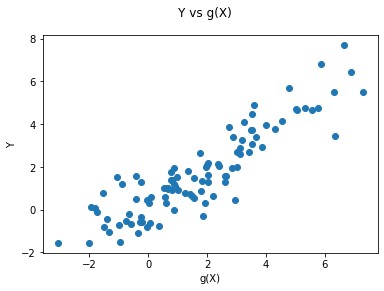

theoretical R2:, 0.7852348130924549


0.7852348130924549

In [46]:
n = 100
p = 400

Z = np.random.uniform( low = 0 , high = 1 , size = n) - 1/2 

W = ( np.random.uniform( low = 0 , high = 1 , size = n * p ) - 1/2 ).\
        reshape( n , p )
mean = 0
sd = 1

beta = ((np.random.normal( mean , sd, p )) * 0.2)
gX = np.exp( 4 * Z ) + (W @ beta)
X = np.concatenate( ( Z.reshape(Z.size, 1), Z.reshape(Z.size, 1) \
                     ** 2, Z.reshape(Z.size, 1) ** 3, W ) , axis = 1 )
random.seed(2)
Y = gX + np.random.normal( mean , sd, n )

# We use package Glmnet to carry out predictions using cross-validated lasso, ridge, and elastic net
fig = plt.figure()
fig.suptitle('Y vs g(X)')
ax = fig.add_subplot(111)
plt.scatter( Y, gX)
plt.xlabel('g(X)')
plt.ylabel('Y')
plt.show()

print( f"theoretical R2:, {np.var(gX) / np.var( Y )}" ) 

np.var(gX) / np.var( Y ) #theoretical R-square in the simulation example

In [47]:
# Reshaping Y variable
Y_vec = Y.reshape( Y.size, 1)

# Scalar distribution
scaler = StandardScaler()
scaler.fit( Y_vec )
std_Y = scaler.transform( Y_vec )

# Regressions
fit_lasso_cv = LassoCV(cv = 10 , random_state = 0 , normalize = True ).fit( X, std_Y )
fit_ridge = ElasticNetCV( cv = 10 , normalize = True , random_state = 0 , l1_ratio = 0.0001 ).fit( X, std_Y )
fit_elnet = ElasticNetCV( cv = 10 , normalize = True , random_state = 0 , l1_ratio = 0.5, max_iter = 100000 ).fit( X, std_Y )

# Predictions
yhat_lasso_cv = scaler.inverse_transform( fit_lasso_cv.predict( X ) )
yhat_ridge = scaler.inverse_transform( fit_ridge.predict( X ) )
yhat_elnet = scaler.inverse_transform( fit_elnet.predict( X ) )

C:\Users\MSI-NB\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\MSI-NB\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\MSI-NB\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [48]:
import statsmodels.api as sm

In [49]:
MSE_lasso_cv = sm.OLS( ((gX - yhat_lasso_cv)**2 ) , np.ones( yhat_lasso_cv.shape )  ).fit().summary2().tables[1].round(3)
MSE_ridge = sm.OLS( ((gX - yhat_ridge)**2 ) , np.ones( yhat_ridge.size )  ).fit().summary2().tables[1].round(3)
MSE_elnet = sm.OLS( ((gX - yhat_elnet)**2 ) , np.ones( yhat_elnet.size )  ).fit().summary2().tables[1].round(3)
# our coefficient of MSE_elnet are far from r output

In [50]:
fit_rlasso = hdmpy.rlasso(X, Y, post = False)
fit_rlasso_post = hdmpy.rlasso(X, Y, post = True)

yhat_rlasso = Y - fit_rlasso.est['residuals'].reshape( Y.size,  )
yhat_rlasso_post = Y - fit_rlasso_post.est['residuals'].reshape( Y.size ,  )

MSE_lasso = sm.OLS( ((gX - yhat_rlasso)**2 ) , np.ones( yhat_rlasso.size )  ).fit().summary2().tables[1].round(3)
MSE_lasso_post = sm.OLS( ((gX - yhat_rlasso_post)**2 ) , np.ones( yhat_rlasso_post.size )  ).fit().summary2().tables[1].round(3)

In [51]:
def lava_predict( x, y, iteration = 5 ):
    
    g1_rlasso = hdmpy.rlasso( x, y , post = False )
    g1 = y - g1_rlasso.est['residuals'].reshape( g1_rlasso.est['residuals'].size, )
    
    new_dep_var = y-g1
    new_dep_var_vec = new_dep_var.reshape( new_dep_var.size, 1 )
    
    # Scalar distribution
    scaler = StandardScaler()
    scaler.fit( new_dep_var_vec )
    std_new_dep_var_vec = scaler.transform( new_dep_var_vec )
    
    fit_ridge_m1 = ElasticNetCV( cv = 10 , normalize = True , random_state = 0 , l1_ratio = 0.0001, alphas = np.array([20]) ).fit( x, std_new_dep_var_vec )
    m1 = scaler.inverse_transform( fit_ridge_m1.predict( x ) )
    
    i = 1
    while i <= iteration:
        
        g1_rlasso = hdmpy.rlasso( x, y , post = False )
        g1 = y - g1_rlasso.est['residuals'].reshape( g1_rlasso.est['residuals'].size, )

        new_dep_var = y-g1
        new_dep_var_vec = new_dep_var.reshape( new_dep_var.size, 1 )

        # Scalar distribution
        scaler = StandardScaler()
        scaler.fit( new_dep_var_vec )
        std_new_dep_var_vec = scaler.transform( new_dep_var_vec )

        fit_ridge_m1 = ElasticNetCV( cv = 10 , normalize = True , random_state = 0 , l1_ratio = 0.0001, alphas = np.array([20]) ).fit( x, std_new_dep_var_vec )
        m1 = scaler.inverse_transform( fit_ridge_m1.predict( x ) )
        
        i = i + 1
        
    return ( g1 + m1 )
        

In [52]:
yhat_lava = lava_predict( X, Y )
MSE_lava = sm.OLS( ((gX - yhat_lava)**2 ) , np.ones( yhat_lava.size )  ).fit().summary2().tables[1].round(3)

C:\Users\MSI-NB\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\MSI-NB\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\MSI-NB\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\MSI-NB\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return 

In [53]:
table2 = np.zeros( (6, 2) )

table2[0, 0:] = MSE_lasso_cv.iloc[0, 0:2].to_list()
table2[1, 0:] = MSE_ridge.iloc[0, 0:2].to_list()
table2[2, 0:] = MSE_elnet.iloc[0, 0:2].to_list()
table2[3, 0:] = MSE_lasso.iloc[0, 0:2].to_list()
table2[4, 0:] = MSE_lasso_post.iloc[0, 0:2].to_list()
table2[5, 0:] = MSE_lava.iloc[0, 0:2].to_list()



table2_pandas = pd.DataFrame( table2, columns = [ "MSA","S.E. for MSA" ])
table2_pandas.index = [ "Cross-Validated Lasso",\
                       "Cross-Validated Ridge", "Cross-Validated elnet",\
                       "Lasso", "Post-Lasso", "Lava" ]
table2_pandas = table2_pandas.round(3)
table2_html = table2_pandas.to_html()
table2_pandas

,MSA,S.E. for MSA
Cross-Validated Lasso,1.303,0.195
Cross-Validated Ridge,3.437,0.488
Cross-Validated elnet,1.510,0.229
Lasso,0.863,0.123
Post-Lasso,1.354,0.186
Lava,0.860,0.122


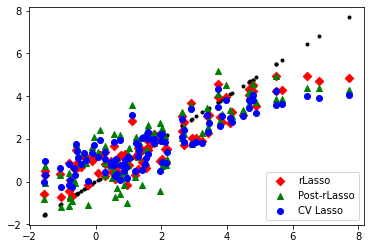

In [54]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter( gX, gX , marker = '.', c = 'black' )
ax1.scatter( gX, yhat_rlasso , marker = 'D' , c = 'red' , label = 'rLasso' )
ax1.scatter( gX, yhat_rlasso_post , marker = '^' , c = 'green' , label = 'Post-rLasso')
ax1.scatter( gX, yhat_lasso_cv , marker = 'o' , c = 'blue' , label = 'CV Lasso')
plt.legend(loc='lower right')
plt.show()